<a href="https://colab.research.google.com/github/apapaioannou92/stockpricing/blob/main/Stock_Modelling_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Stock Pricing Modelling**

---



##Installing libraries

In [1]:
%%capture
#!/usr/bin/env python

#import modules
!pip install -U -q PyDrive
!source activate py36
!pip install fix-yahoo-finance
!pip install pandas_datareader
!pip install yfinance
!pip install bokeh
# !pip install SciencePlots
# !pip install latex

##Installing modules

In [3]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

#for downloading exported files
from google.colab import files
from google.colab import drive
drive.mount('/content/gdrive')

# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

#Importing bokeh module for nice graphs
from bokeh.io import output_notebook
output_notebook()

import math
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import datetime as dt 
import yfinance as yf
import statsmodels.api as sm

#For visualization purposes
%matplotlib inline 
plt.rcParams.update({'font.size': 10,
                     'axes.titlesize': 18,
                     'axes.labelsize': 16,
                     'axes.labelpad': 12,
                     'lines.linewidth': 1,
                     'lines.markersize': 8,
                     'xtick.labelsize' : 14,
                     'ytick.labelsize' : 14,
                     'xtick.top' : True,
                     'xtick.direction' : 'in',
                     'ytick.right' : True,
                     'ytick.direction' : 'in',})

#For Kolmogorov-Smirnov test of normality
from scipy.stats import kstest
from scipy.stats import ks_2samp

#For simulation purposes
import random
from numpy.random import seed
import math
# set seed (e.g. make this example reproducible)
# seed(0)

from time import time
from math import exp, sqrt, log
from random import gauss

import scipy
# plt.style.use('science')
# plt.style.reload_library()

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


##Data scrapping

In [55]:
df = yf.download("HPQ", start="1996-01-01", end="2006-12-31", group_by="ticker")
df['Daily Return, St/St-1']=df['Adj Close']/df['Adj Close'].shift(1)
df['Ln Daily Return']=np.log(df['Adj Close']/df['Adj Close'].shift(1))
df['Mu Daily']=(df['Ln Daily Return']+df['Ln Daily Return'].shift(1))/2
df['Sigma Daily']=df['Ln Daily Return'].rolling(2).std()
df.reset_index(inplace=True)
df = df.rename(columns = {'Date':'Date'})
min_=min(df['Date'].dt.year)
max_=max(df['Date'].dt.year)
len_=max_-min_
# print(len_)
df.head()

[*********************100%***********************]  1 of 1 completed


,Date,Open,High,Low,Close,Adj Close,Volume,"Daily Return, St/St-1",Ln Daily Return,Mu Daily,Sigma Daily
0,1996-01-02,9.508401,9.565168,9.338102,9.480018,4.711777,12991800,NaN,NaN,NaN,NaN
1,1996-01-03,9.480018,9.550976,9.210377,9.267144,4.605974,14481233,0.977545,-0.022711,NaN,NaN
2,1996-01-04,9.267144,9.352293,8.883969,9.054269,4.500172,31343268,0.977029,-0.023239,-0.022975,0.000373
3,1996-01-05,9.054269,9.167802,8.926544,8.983311,4.464903,20288347,0.992163,-0.007868,-0.015553,0.010869
4,1996-01-08,8.983311,9.082652,8.969119,9.040077,4.493116,7309759,1.006319,0.006299,-0.000785,0.010017


##Visualization

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


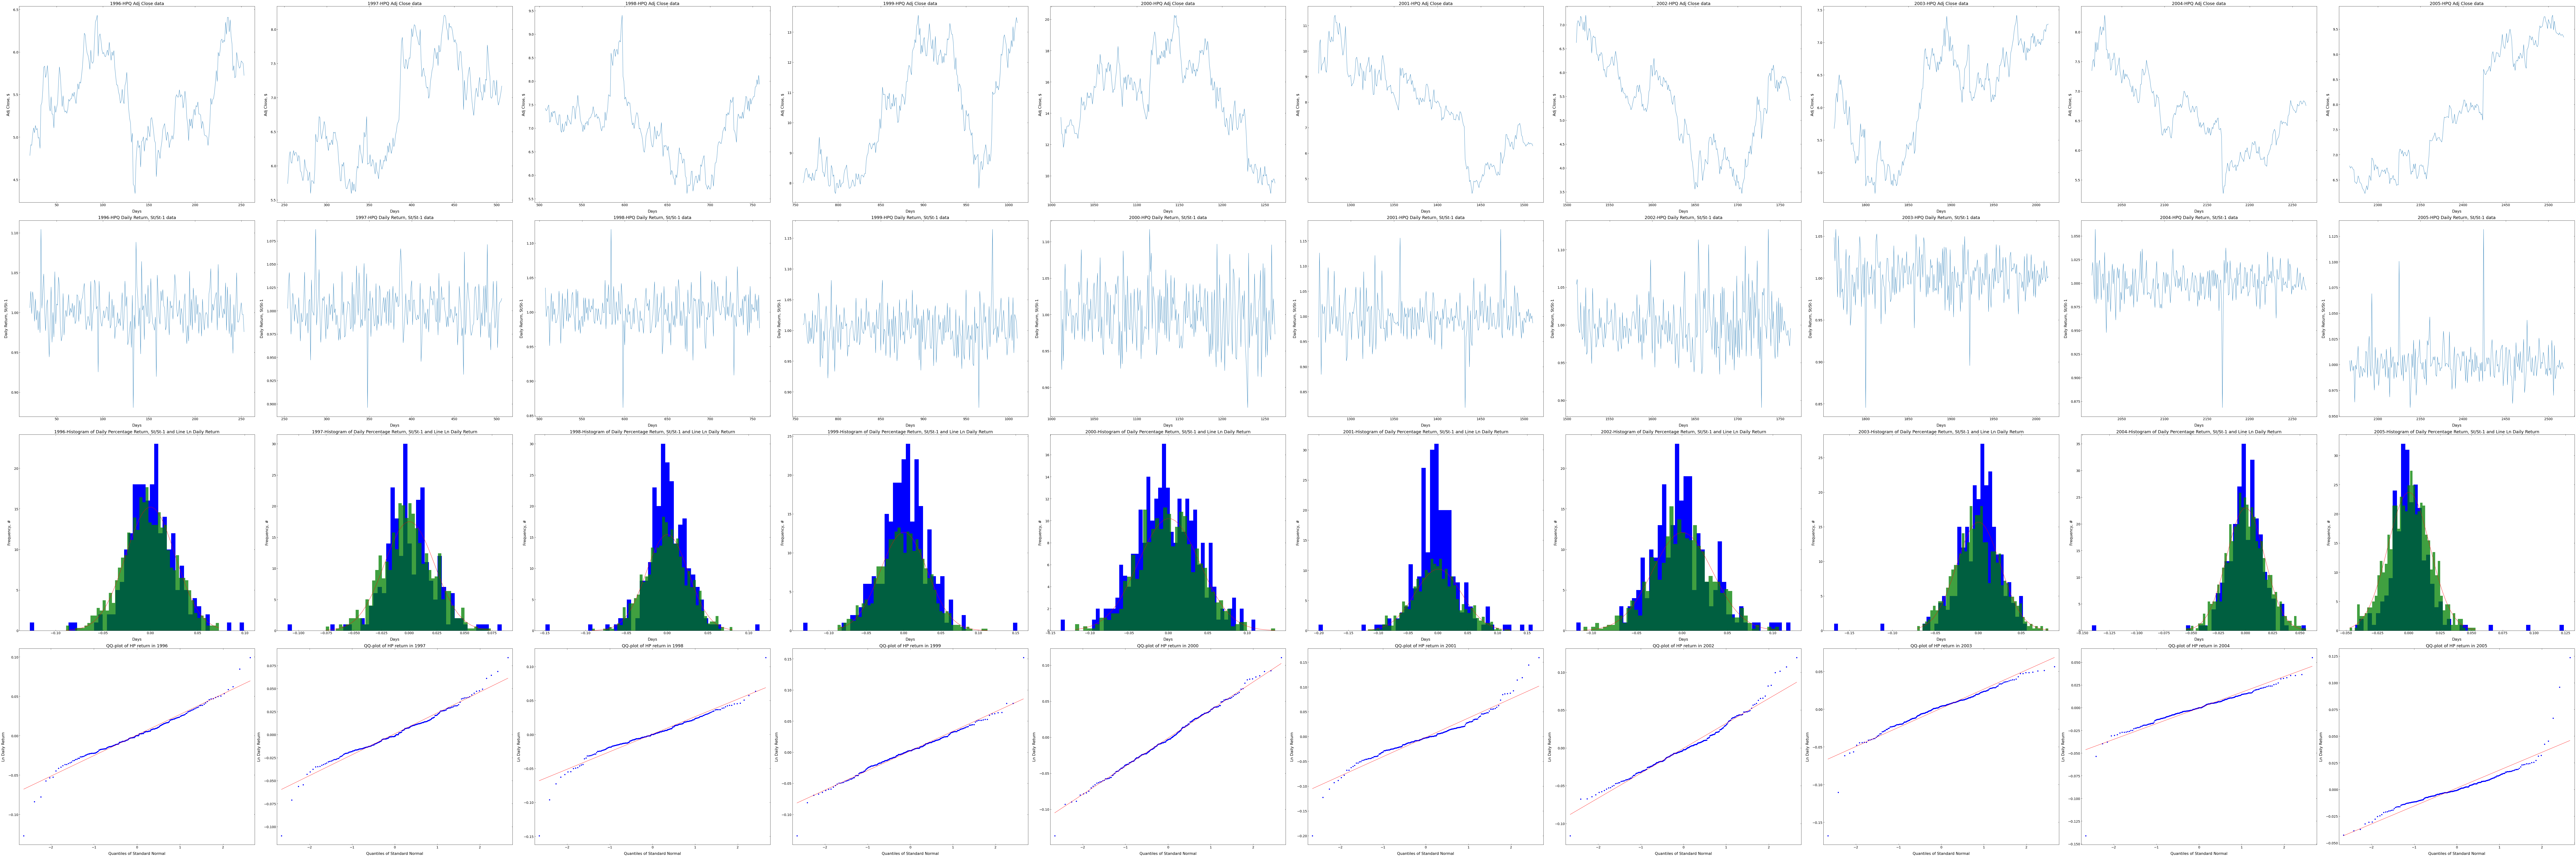

In [86]:
ktest_statistic_list = []
ktest_pvalue_list = []
year = []

mu_daily_avg_list = [] 
mu_annual_avg_list = []
sigma_daily_avg_list = []
sigma_annual_avg_list = []

fig, axs = plt.subplots(4, 10, figsize=(150,50))
fig.tight_layout()

for i in range(0, len_):
  df = yf.download("HPQ", start="1996-01-01", end="2006-12-31", group_by="ticker")
  df['Daily Return, St/St-1']=df['Adj Close']/df['Adj Close'].shift(1)
  df['Ln Daily Return']=np.log(df['Adj Close']/df['Adj Close'].shift(1))
  df['Mu Daily']=df['Ln Daily Return'].rolling(21).mean()
  df['Sigma Daily']=df['Ln Daily Return'].rolling(21).std()
  df['Sigma Annually'] = df['Sigma Daily']*math.sqrt(252) 
  df.reset_index(inplace=True)
  df = df.rename(columns = {'Date':'Date'})
  year_mask = i+min_
  df = df[df['Date'].dt.year==year_mask]

  df_qq = df
  df_qq.dropna(inplace=True)

  axs[0, i].plot(df['Adj Close'])
  axs[0, i].set_xlabel("Days")
  axs[0, i].set_ylabel("Adj Close, $")
  axs[0, i].set_title(str(min_+i)+"-HPQ Adj Close data")

  axs[1, i].plot(df['Daily Return, St/St-1'])
  axs[1, i].set_xlabel("Days")
  axs[1, i].set_ylabel("Daily Return, St/St-1")
  axs[1, i].set_title(str(min_+i)+"-HPQ Daily Return, St/St-1 data")

  axs[2, i].hist(df['Ln Daily Return'], bins=50, facecolor='blue', histtype='barstacked') #histtype='step'
  #axs[2, i].plot(df['Ln Daily Return'],kde(ax=axs[2]) #using KDE built-in function

  #1st try
  #x = df['Mu Daily'].mean()+df['Sigma Daily'].mean()*np.random.randn(1000)
  #2nd try
  # mu = df['Ln Daily Return'].mean()
  # sigma = df['Ln Daily Return'].std()
  # x = mu+sigma*np.random.randn(1000)
  #3rd try
  # mu = df['Ln Daily Return'].mean()
  # sigma = df['Ln Daily Return'].std()
  # x = sigma*np.random.randn(1000)
  #4th try
  # sigma = df['Ln Daily Return'].std() #unbiased_estimator_v_std_log_returns according to https://quant.stackexchange.com/questions/55220/simulate-stock-prices-with-geometric-brownian-motion-motion-with-mu-and-signa-ba
  # mu = df['Ln Daily Return'].mean()+0.5*pow(sigma,2) #unbiased_estimator_u_bar_log_returns
  # x = mu+sigma*np.random.randn(1000)
  #5th try
  # sigma = df['Ln Daily Return'].std() #unbiased_estimator_v_std_log_returns according to https://quant.stackexchange.com/questions/55220/simulate-stock-prices-with-geometric-brownian-motion-motion-with-mu-and-signa-ba
  # mu = (df['Ln Daily Return'].mean()/252)+0.5*pow(sigma,2) #unbiased_estimator_u_bar_log_returns
  # x = mu+sigma*np.random.randn(1000)
  #6th try
  sigma = df['Ln Daily Return'].std() #unbiased_estimator_v_std_log_returns according to https://quant.stackexchange.com/questions/55220/simulate-stock-prices-with-geometric-brownian-motion-motion-with-mu-and-signa-ba
  mu = (df['Ln Daily Return'].mean()/252)+0.5*pow(sigma,2) #unbiased_estimator_u_bar_log_returns
  x = sigma*np.random.randn(1000)

  #print('Mu:', mu,'Sigma:', sigma,'df[Sigma Daily].mean():', df['Sigma Daily'].mean(), 'df[Sigma Annually].mean():', df['Sigma Annually'].mean())

  n, bins, patches = axs[2,i].hist(x, 50, density=1, facecolor='green', alpha=0.75)

  y = scipy.stats.norm.pdf(bins, mu, sigma)
  axs[2, i].plot(bins, y, 'r-', linewidth=1)
  axs[2, i].set_xlabel("Days")
  axs[2, i].set_ylabel("Frequency, #")
  axs[2, i].set_title(str(min_+i)+"-Histogram of Daily Percentage Return, St/St-1 and Line Ln Daily Return")

  sm.qqplot(df_qq['Ln Daily Return'], dist='norm', line='s', ax=axs[3,i], marker='.')
  axs[3, i].set_xlabel("Quantiles of Standard Normal")
  axs[3, i].set_ylabel("Ln Daily Return")
  axs[3, i].set_title("QQ-plot of HP return in "+str(min_+i))

  ktest_statistic_list.append(ks_2samp(x, df['Ln Daily Return']).statistic)
  ktest_pvalue_list.append(ks_2samp(x, df['Ln Daily Return']).pvalue)
  year.append(max(df['Date'].dt.year))

  mu_daily_avg = np.mean(df['Mu Daily'])
  mu_annual_avg = (df['Ln Daily Return'].mean()/252)+0.5*pow(sigma,2)
  sigma_daily_avg = np.mean(df['Sigma Daily'])
  sigma_annual_avg = sigma_daily_avg*math.sqrt(252)
  
  mu_daily_avg_list.append(mu_daily_avg)
  mu_annual_avg_list.append(mu_annual_avg)
  sigma_daily_avg_list.append(sigma_daily_avg)
  sigma_annual_avg_list.append(sigma_annual_avg)

plt.tight_layout()
# plt.savefig('gdrive/MyDrive/Stock_Pricing_modelling_final.png')
# plt.savefig('gdrive/MyDrive/Colab Notebooks/Stock_Pricing_modelling.png')
plt.show()

##Kolmogorov-Smirnov test of normality

In [87]:
df_ks_test = pd.DataFrame(list(zip(year, ktest_statistic_list, ktest_pvalue_list)), columns =['Year', 'statistic', 'p-value'])
df_ks_test.head(10)

,Year,statistic,p-value
0,1996,0.075867,0.213840
1,1997,0.081423,0.128781
2,1998,0.090333,0.069652
3,1999,0.080111,0.141706
4,2000,0.047159,0.740152
5,2001,0.086581,0.094944
6,2002,0.092317,0.060085
7,2003,0.116365,0.007773
8,2004,0.071857,0.236132
9,2005,0.097762,0.039410


###1st try
x = df['Mu Daily'].mean()+df['Sigma Daily'].mean()*np.random.randn(1000)
\begin{array}{|l|l|l|l|}
  \hline
  & Year & statistic & p-value  \\
  \hline
0 & 1996 & 0.055279  & 0.587523 \\
1 & 1997 & 0.057704  & 0.490598 \\
2 & 1998 & 0.083365  & 0.114083 \\
3 & 1999 & 0.033333  & 0.972122 \\
4 & 2000 & 0.047159  & 0.740152 \\
5 & 2001 & 0.10571   & 0.021609 \\
6 & 2002 & 0.062317  & 0.395945 \\
7 & 2003 & 0.089571  & 0.073654 \\
8 & 2004 & 0.074238  & 0.204994 \\
9 & 2005 & 0.09154   & 0.063693 \\
  \hline
\end{array}

###2nd try
  x = df['Ln Daily Return'].mean()+df['Ln Daily Return'].std()*np.random.randn(1000)

\begin{array}{|l|l|l|l|}
  \hline
  & Year & statistic & p-value  \\
  \hline
0 & 1996 & 0.077871  & 0.190069 \\
1 & 1997 & 0.067597  & 0.298693 \\
2 & 1998 & 0.087365  & 0.086361 \\
3 & 1999 & 0.045302  & 0.782492 \\
4 & 2000 & 0.035651  & 0.950355 \\
5 & 2001 & 0.132548  & 0.001649 \\
6 & 2002 & 0.073317  & 0.216641 \\
7 & 2003 & 0.070429  & 0.256473 \\
8 & 2004 & 0.08846   & 0.079842 \\
9 & 2005 & 0.117873  & 0.006731 \\
  \hline
\end{array}

###3rd try
  x = df['Ln Daily Return'].std()*np.random.randn(1000)

  \begin{array}{|l|l|l|l|}
  \hline
  & Year & statistic & p-value  \\
  \hline
  0 & 1996 & 0.057279  & 0.542224 \\
  1 & 1997 & 0.052423  & 0.612905 \\
  2 & 1998 & 0.071365  & 0.243008 \\
  3 & 1999 & 0.07      & 0.262792 \\
  4 & 2000 & 0.045159  & 0.785658 \\
  5 & 2001 & 0.113548  & 0.010823 \\
  6 & 2002 & 0.094317  & 0.051605 \\
  7 & 2003 & 0.09754   & 0.040113 \\
  8 & 2004 & 0.097302  & 0.040878 \\
  9 & 2005 & 0.095778  & 0.046089 \\
  \hline
\end{array}

###4th try
sigma = df['Ln Daily Return'].std() #unbiased_estimator_v_std_log_returns according to https://quant.stackexchange.com/questions/55220/simulate-stock-prices-with-geometric-brownian-motion-motion-with-mu-and-signa-ba
mu = df['Ln Daily Return'].mean()+0.5*pow(sigma,2) #unbiased_estimator_u_bar_log_returns
x = mu+sigma*np.random.randn(1000)

  \begin{array}{|l|l|l|l|}
  \hline
  & Year & statistic & p-value  \\
  \hline
  0 & 1996 & 0.066279  & 0.359138 \\
  1 & 1997 & 0.050423  & 0.660825 \\
  2 & 1998 & 0.061333  & 0.415622 \\
  3 & 1999 & 0.050937  & 0.650511 \\
  4 & 2000 & 0.069159  & 0.275574 \\
  5 & 2001 & 0.139548  & 0.000766 \\
  6 & 2002 & 0.080317  & 0.139802 \\
  7 & 2003 & 0.05419   & 0.573149 \\
  8 & 2004 & 0.087302  & 0.086752 \\
  9 & 2005 & 0.111492  & 0.012221 \\
  \hline
\end{array}

### 5th try
sigma = df['Ln Daily Return'].std() #unbiased_estimator_v_std_log_returns according to https://quant.stackexchange.com/questions/55220/simulate-stock-prices-with-geometric-brownian-motion-motion-with-mu-and-signa-ba
mu = (df['Ln Daily Return'].mean()/252)+0.5*pow(sigma,2) #unbiased_estimator_u_bar_log_returns
x = mu+sigma*np.random.randn(1000)

  \begin{array}{|l|l|l|l|}
  \hline
  & Year & statistic & p-value  \\
  \hline
  0 & 1996 & 0.090279  & 0.085538 \\
  1 & 1997 & 0.070423  & 0.25477  \\
  2 & 1998 & 0.092333  & 0.060015 \\
  3 & 1999 & 0.080429  & 0.138794 \\
  4 & 2000 & 0.045651  & 0.774669 \\
  5 & 2001 & 0.113581  & 0.010791 \\
  6 & 2002 & 0.116317  & 0.007809 \\
  7 & 2003 & 0.093397  & 0.055373 \\
  8 & 2004 & 0.066857  & 0.312776 \\
  9 & 2005 & 0.100952  & 0.030437 \\
  \hline
\end{array}

### 6th try
sigma = df['Ln Daily Return'].std() #unbiased_estimator_v_std_log_returns according to https://quant.stackexchange.com/questions/55220/simulate-stock-prices-with-geometric-brownian-motion-motion-with-mu-and-signa-ba
  mu = (df['Ln Daily Return'].mean()/252)+0.5*pow(sigma,2) #unbiased_estimator_u_bar_log_returns
  x = sigma*np.random.randn(1000)

  \begin{array}{|l|l|l|l|}
  \hline
  & Year & statistic & p-value  \\
  \hline
  0 & 1996 & 0.062451  & 0.432001 \\
  1 & 1997 & 0.063897  & 0.363501 \\
  2 & 1998 & 0.074492  & 0.201871 \\
  3 & 1999 & 0.064397  & 0.35629  \\
  4 & 2000 & 0.042159  & 0.848739 \\
  5 & 2001 & 0.096548  & 0.045544 \\
  6 & 2002 & 0.064317  & 0.357746 \\
  7 & 2003 & 0.083508  & 0.112977 \\
  8 & 2004 & 0.083857  & 0.110323 \\
  9 & 2005 & 0.109873  & 0.014143 \\
  \hline
\end{array}

##Parameters estimation

In [88]:
df_mu_sigma = pd.DataFrame(list(zip(year, mu_daily_avg_list, mu_annual_avg_list, sigma_daily_avg_list, sigma_annual_avg_list)), 
                           columns =['Year', 'mu_daily_avg', 'mu_annualized', 'sigma_daily_avg', 'sigma_annualized',])
df_mu_sigma.head(10)

,Year,mu_daily_avg,mu_annualized,sigma_daily_avg,sigma_annualized
0,1996,0.001223,0.000346,0.025551,0.405610
1,1997,0.000706,0.000263,0.022249,0.353186
2,1998,0.000253,0.000336,0.025053,0.397708
3,1999,0.001985,0.000505,0.030183,0.479137
4,2000,-0.001032,0.000759,0.037908,0.601768
5,2001,-0.001575,0.000757,0.038630,0.613227
6,2002,-0.000517,0.000542,0.031292,0.496748
7,2003,0.000814,0.000328,0.024724,0.392475
8,2004,-0.000192,0.000149,0.016137,0.256168
9,2005,0.001360,0.000147,0.015969,0.253493


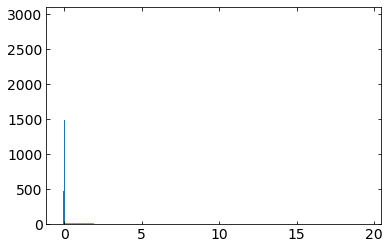

In [ ]:
# plt.hist(x)
# plt.hist(y)
# plt.hist(df['Ln Daily Return'])
# plt.hist(np.log(y))
# plt.show()

In [ ]:
from scipy.stats import anderson
# seed the random number generator
seed(1)
# generate univariate observations
data = x #df_qq['Ln Daily Return'] #sigma*np.random.randn(10000)
# normality test
result = anderson(data)
print('Statistic: %.3f' % result.statistic)
p = 0
for i in range(len(result.critical_values)):
	sl, cv = result.significance_level[i], result.critical_values[i]
	if result.statistic < result.critical_values[i]:
		print('%.3f: %.3f, data looks normal (fail to reject H0)' % (sl, cv))
	else:
		print('%.3f: %.3f, data does not look normal (reject H0)' % (sl, cv))

Statistic: 0.294
15.000: 0.576, data looks normal (fail to reject H0)
10.000: 0.656, data looks normal (fail to reject H0)
5.000: 0.787, data looks normal (fail to reject H0)
2.500: 0.918, data looks normal (fail to reject H0)
1.000: 1.092, data looks normal (fail to reject H0)


##Simulation

In [ ]:
mu_daily_avg_list = [] 
mu_annual_avg_list = []
sigma_daily_avg_list = []
sigma_annual_avg_list = []

for i in range(0, len_):
  df = yf.download("HPQ", start="1996-01-01", end="2006-12-31", group_by="ticker")
  df['Daily Return, St/St-1'] = df['Adj Close']/df['Adj Close'].shift(1)
  df['Ln Daily Return'] = np.log(df['Adj Close']/df['Adj Close'].shift(1))
  df['Mu Daily']=(df['Ln Daily Return']+df['Ln Daily Return'].shift(1))/2
  df['Sigma Daily']=df['Ln Daily Return'].rolling(2).std()
  df.reset_index(inplace=True)
  df = df.rename(columns = {'Date':'Date'})
  year_mask = i+min_
  df = df[df['Date'].dt.year==year_mask]

  # mu_daily_avg = np.mean(df['Mu Daily'])
  # mu_annual_avg = len(df['Ln Daily Return'])*mu_daily_avg
  # sigma_daily_avg = np.mean(df['Sigma Daily'])
  # sigma_annual_avg = len(df['Ln Daily Return'])*sigma_daily_avg

  #Setting a seed for reproducible results
  np.random.seed(9713)

  # Parameters

  series=df['Adj Close'].values

  S0 = series[0]
  dt = 1/252
  n = 252
  # Times
  T = dt*n
  ts = np.linspace(dt, T, n)

  mu = mu_annual_avg_list[i] #np.mean(series)
  sigma = sigma_annual_avg_list[i] #np.std(series) #np.sqrt( ( np.diff(series)**2 ).sum() / (n * dt) )

  # Geometric Brownian motion generator
  def gbm(mu, sigma, S0, n, dt):
      step = np.exp( (mu - sigma**2 / 2) * dt ) * np.exp( sigma * np.random.normal(0, np.sqrt(dt), (1, n)))
      #St = path[t - 1] * exp((mu - 0.5 * sigma ** 2) * dt + sigma * sqrt(dt) * epsilon_) 
      return S0 * step.cumprod()

  # Estimate mu just from the series end-points
  # Note this is for a linear drift-diffusion process, i.e. the log of GBM
  def simple_estimate_mu(series):
      return (series[-1] - S0) / T

  # Use all the increments combined (maximum likelihood estimator)
  # Note this is for a linear drift-diffusion process, i.e. the log of GBM
  def incremental_estimate_mu(series):
      total = (1.0 / dt) * (ts**2).sum()
      return (1.0 / total) * (1.0 / dt) * ( ts * series ).sum()

  # This just estimates the sigma by its definition as the infinitesimal variance (simple Monte Carlo)
  # Note this is for a linear drift-diffusion process, i.e. the log of GBM
  # One can do better than this of course (MLE?)
  def estimate_sigma(series):
      return np.sqrt( ( np.diff(series)**2 ).sum() / (n * dt) )

  # Estimator helper
  all_estimates0 = lambda s: (simple_estimate_mu(s), incremental_estimate_mu(s), estimate_sigma(s))

  # Since log-GBM is a linear Ito drift-diffusion process (scaled Wiener process with drift), we
  # take the log of the realizations, compute mu and sigma, and then translate the mu and sigma
  # to that of the GBM (instead of the log-GBM). (For sigma, nothing is required in this simple case).
  def gbm_drift(log_mu, log_sigma):
    return log_mu + 0.5 * log_sigma**2

  # Translates all the estimates from the log-series
  def all_estimates(es):
    lmu1, lmu2, sigma = all_estimates0(es)
    return gbm_drift(lmu1, sigma), gbm_drift(lmu2, sigma), sigma

  print('Real Mu:', mu)
  print('Real Sigma:', sigma)

  ### Using one series ###
  series = gbm(mu, sigma, S0, n, dt)
  log_series = np.log(series)

  print('Using 1 series: mu1 = %.2f, mu2 = %.2f, sigma = %.2f' % all_estimates(log_series) )

  ### Using K series ###
  K = 10000
  s = [ np.log(gbm(mu, sigma, S0, n, dt)) for i in range(K) ]
  e = np.array( [ all_estimates(si) for si in s ] )
  avgs = np.mean(e, axis=0)

  print('Using %d series: mu1 = %.2f, mu2 = %.2f, sigma = %.2f' % (K, avgs[0], avgs[1], avgs[2]) )

[*********************100%***********************]  1 of 1 completed


IndexError: ignored

CPU times: user 2.08 s, sys: 9.56 ms, total: 2.09 s
Wall time: 2.09 s


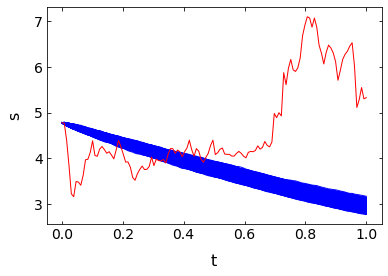

In [ ]:
def genS_py(runs):
  ''' I: number of paths '''
  S = []
  for k in range(runs):
    path = []
    for t in range(N):
      if t == 0: 
        path.append(S0)
      else:
        epsilon_ = gauss(0.0, 1.0)
        St = path[t - 1] * exp((mu - 0.5 * sigma ** 2) * dt + sigma * sqrt(dt) * epsilon_) 
        path.append(St)
    S.append(path) 
  return S
#Setting a seed for reproducible results
# np.random.seed(9713)

# Parameters
S0 = df['Adj Close'].iloc[0]
mu = -0.48089482917661885#mu_daily_avg_list[0]#0.05#mu_annual_avg_list[0] #mu_annual_avg
sigma = 0.017#50*sigma_daily_avg_list[0]#(df['Adj Close'].iloc[-1] - S0) / T#sigma_annual_avg_list[0]/10#0.2#sigma_annual_avg_list[0] #sigma_annual_avg

# u = df['Ln Daily Return'].mean()
# sigma = df['Ln Daily Return'].std()
# mu = u+(1/2)*sigma**2

T = 1.0; N = len(df); dt = T / N
epsilon_=np.random.standard_normal()

runs = 10000
%time S = genS_py(runs) 
t = np.linspace(0.0, N*dt, N)

for j in range(runs):
  plt.plot(t, S[j], 'b')
plt.plot(t, df['Adj Close'], 'r')
# plt.xlim([0, 1])
# plt.ylim([-100, 400])
plt.xlabel('t', fontsize=16)
plt.ylabel('s', fontsize=16)
plt.show()

[*********************100%***********************]  1 of 1 completed
CPU times: user 340 ms, sys: 1.01 ms, total: 341 ms
Wall time: 339 ms
[*********************100%***********************]  1 of 1 completed
CPU times: user 340 ms, sys: 1.97 ms, total: 342 ms
Wall time: 340 ms
[*********************100%***********************]  1 of 1 completed
CPU times: user 335 ms, sys: 960 µs, total: 336 ms
Wall time: 336 ms
[*********************100%***********************]  1 of 1 completed
CPU times: user 334 ms, sys: 0 ns, total: 334 ms
Wall time: 333 ms
[*********************100%***********************]  1 of 1 completed
CPU times: user 338 ms, sys: 2.94 ms, total: 341 ms
Wall time: 339 ms
[*********************100%***********************]  1 of 1 completed
CPU times: user 336 ms, sys: 1.91 ms, total: 338 ms
Wall time: 338 ms
[*********************100%***********************]  1 of 1 completed
CPU times: user 343 ms, sys: 1.94 ms, total: 345 ms
Wall time: 344 ms
[*********************100%*****

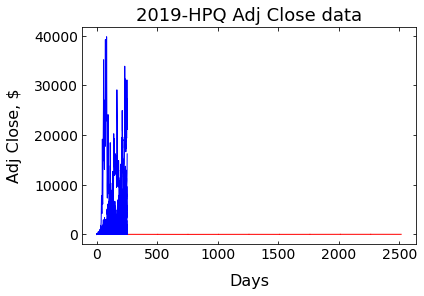

In [ ]:
# http://archive.eclass.uth.gr/eclass/modules/document/file.php/MHX305/Assignments/assignment3.pdf
# Simulating Geometric Brownian Motion with Python #

# Parameter Definitions

# So    :   initial stock price
# dt    :   time increment -> a day in our case
# T     :   length of the prediction time horizon (how many time points to predict, same unit with dt(days))
# N     :   number of time points in the prediction time horizon -> T/dt
# t     :   array for time points in the prediction time horizon [1, 2, 3, .. , N]
# mu    :   mean of historical daily returns
# sigma :   standard deviation of historical daily returns
# b     :   array for brownian increments
# W     :   array for brownian path

# Parameters

#Then we define a function which returns us I simulated index level paths. # Simulating I paths with M time steps
def genS_py(I):
  ''' I: number of paths '''
  S = []
  for k in range(I):
    path = []
    for t in range(N+1):
      if t == 0: 
        path.append(S0)
      else:
        epsilon_ = gauss(0.0, 1.0)
        St = path[t - 1] * exp((mu - 0.5 * sigma ** 2) * dt + sigma * sqrt(dt) * epsilon_) 
        path.append(St)
    S.append(path) 
  return S

for i in range(0, len_):
  S = []
  df = yf.download("HPQ", start="2010-01-01", end="2020-12-31", group_by="ticker")
  df['Ln Daily Return'] = np.log(df['Adj Close']/df['Adj Close'].shift(1))
  df['Mu Daily']=(df['Ln Daily Return']+df['Ln Daily Return'].shift(1))/2
  df['Sigma Daily']=df['Ln Daily Return'].rolling(2).std()
  df.reset_index(inplace=True)
  df = df.rename(columns = {'Date':'Date'})
  year_mask = i+min_
  df = df[df['Date'].dt.year==year_mask]

  # mu_daily_avg = np.mean(df['Mu Daily'])
  # mu_annual_avg = len(df['Ln Daily Return'])*mu_daily_avg
  # sigma_daily_avg = np.mean(df['Sigma Daily'])
  # sigma_annual_avg = len(df['Ln Daily Return'])*sigma_daily_avg

  #Setting a seed for reproducible results
  np.random.seed(9713)

  # Parameters
  S0 = 18#df['Adj Close'].iloc[0]
  mu = mu_annual_avg_list[i] #mu_annual_avg
  sigma = sigma_annual_avg_list[i] #sigma_annual_avg
  T = 1.0; N = len(df); dt = T / N
  epsilon_=np.random.standard_normal()

  #Let's see how long the simulation takes.
  I = 1000
  %time S = genS_py(I) 
  # Wall time: 6.99 s
  t = np.linspace(0.0, N*dt, N)

  #Plot the results of simulation 
  plt.plot(df['Adj Close'], 'r')
  plt.xlabel("Days")
  plt.ylabel("Adj Close, $")
  plt.title(str(min_+i)+"-HPQ Adj Close data")
  for j in range(I):
    plt.plot(S[j], 'b')

plt.show()

https://www.youtube.com/watch?v=_T0l015ecK4

#Draft

##Visualization

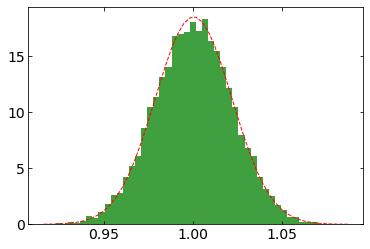

In [ ]:
fig = plt.figure()
# ax = fig.add_axes([0.1,0.1,0.8,0.8])
# x = np.linspace(min(df['Daily Return, Si/Si-1']), max(df['Daily Return, Si/Si-1']), len(df))
mu = df['Daily Return, Si/Si-1'].mean()
sigma = df['Daily Return, Si/Si-1'].std()
# print(mu,sigma)
x = mu + sigma*np.random.randn(10000)
# the histogram of the data using average mu and sigma and gaussian
n, bins, patches = plt.hist(x, 50, density=1, facecolor='green', alpha=0.75)
# axs[0].hist(x, bins=50, density=1, facecolor='green')
# ax = plt.hist(x,bins=100)
# add a 'best fit' line
y = scipy.stats.norm.pdf(bins, mu, sigma)
l = plt.plot(bins, y, 'r--', linewidth=1)
# ax = plt.hist(y, bins)
plt.show()

In [ ]:
from bokeh.plotting import figure, show
# create a new plot with a title and axis labels
p = figure(title="Daily Adj Close", x_axis_label="Days", y_axis_label="Stock price, $")
# add a line renderer with legend and line thickness to the plot
p.line(df['Date'], df['Adj Close'], line_width=0.5)
# change just some things about the x-grid
p.xgrid.grid_line_color = None

# change just some things about the y-grid
p.ygrid.grid_line_alpha = 0.5
show(p)

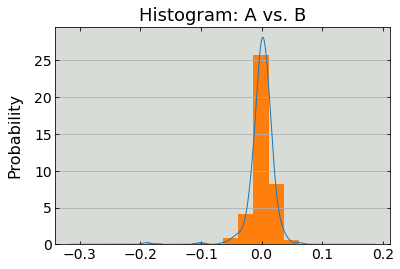

In [ ]:
fig, ax = plt.subplots()
df['Ln Daily Return'].plot.kde(ax=ax, legend=False, title='Histogram: A vs. B')
df['Ln Daily Return'].plot.hist(density=True, ax=ax)
ax.set_ylabel('Probability')
ax.grid(axis='y')
ax.set_facecolor('#d8dcd6')

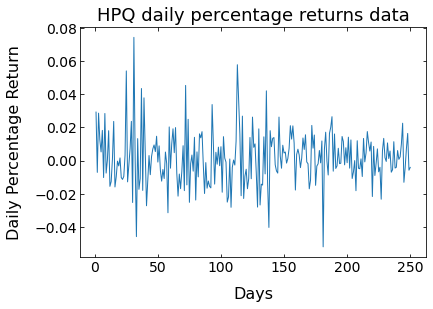

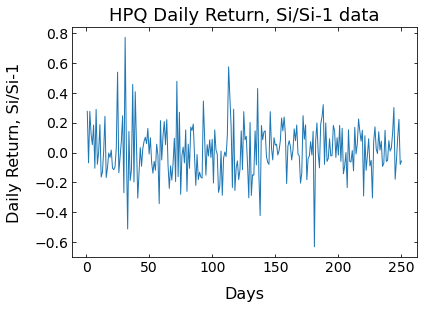

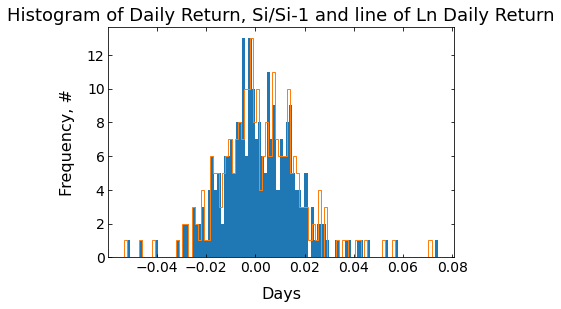

In [ ]:
fig1 = plt.figure()
ax1 = fig1.add_axes([0.1,0.1,0.8,0.8])
ax1.plot(df['Daily Percentage Return'])
ax1.set_xlabel("Days")
ax1.set_ylabel("Daily Percentage Return")
ax1.set_title("HPQ daily percentage returns data")
# plt.savefig('filename.pdf')
plt.show()

fig2 = plt.figure()
ax2 = fig2.add_axes([0.1,0.1,0.8,0.8])
ax2.plot(df['Daily Return, Si/Si-1'])
ax2.set_xlabel("Days")
ax2.set_ylabel("Daily Return, Si/Si-1")
ax2.set_title("HPQ Daily Return, Si/Si-1 data")
# plt.savefig('filename.pdf')
plt.show()

fig3 = plt.figure()
ax3 = fig3.add_axes([0.1,0.1,0.8,0.8])
x = np.linspace(min(df['Daily Return, Si/Si-1']), max(df['Daily Return, Si/Si-1']), len(df))
# ax3 = df['Daily Return, Si/Si-1'].plot.hist(bins=100)
ax3 = df['Daily Percentage Return'].plot.hist(bins=100)
ax3 = df['Ln Daily Return'].plot.hist(bins=100, histtype='step')
ax3.set_xlabel("Days")
ax3.set_ylabel("Frequency, #")
ax3.set_title("Histogram of Daily Return, Si/Si-1 and line of Ln Daily Return")
# fig.tight_layout()
# plt.savefig('filename.pdf')
plt.show()

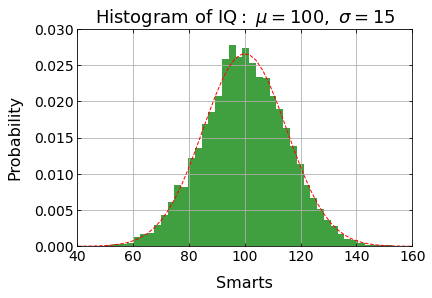

In [ ]:
import numpy as np
import scipy
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt

mu, sigma = 100, 15
x = mu + sigma*np.random.randn(10000)

# the histogram of the data
n, bins, patches = plt.hist(x, 50, density=1, facecolor='green', alpha=0.75)

# add a 'best fit' line
y = scipy.stats.norm.pdf(bins, mu, sigma)
l = plt.plot(bins, y, 'r--', linewidth=1)

plt.xlabel('Smarts')
plt.ylabel('Probability')
plt.title(r'$\mathrm{Histogram\ of\ IQ:}\ \mu=100,\ \sigma=15$')
plt.axis([40, 160, 0, 0.03])
plt.grid(True)

plt.show()

##Simulation

In [ ]:
"""
brownian() implements one dimensional Brownian motion (i.e. the Wiener process).
"""

# File: brownian.py

from math import sqrt
from scipy.stats import norm
import numpy as np


def brownian(x0, n, dt, delta, out=None):
    """
    Generate an instance of Brownian motion (i.e. the Wiener process):

        X(t) = X(0) + N(0, delta**2 * t; 0, t)

    where N(a,b; t0, t1) is a normally distributed random variable with mean a and
    variance b.  The parameters t0 and t1 make explicit the statistical
    independence of N on different time intervals; that is, if [t0, t1) and
    [t2, t3) are disjoint intervals, then N(a, b; t0, t1) and N(a, b; t2, t3)
    are independent.
    
    Written as an iteration scheme,

        X(t + dt) = X(t) + N(0, delta**2 * dt; t, t+dt)


    If `x0` is an array (or array-like), each value in `x0` is treated as
    an initial condition, and the value returned is a numpy array with one
    more dimension than `x0`.

    Arguments
    ---------
    x0 : float or numpy array (or something that can be converted to a numpy array
         using numpy.asarray(x0)).
        The initial condition(s) (i.e. position(s)) of the Brownian motion.
    n : int
        The number of steps to take.
    dt : float
        The time step.
    delta : float
        delta determines the "speed" of the Brownian motion.  The random variable
        of the position at time t, X(t), has a normal distribution whose mean is
        the position at time t=0 and whose variance is delta**2*t.
    out : numpy array or None
        If `out` is not None, it specifies the array in which to put the
        result.  If `out` is None, a new numpy array is created and returned.

    Returns
    -------
    A numpy array of floats with shape `x0.shape + (n,)`.
    
    Note that the initial value `x0` is not included in the returned array.
    """

    x0 = np.asarray(x0)

    # For each element of x0, generate a sample of n numbers from a
    # normal distribution.
    r = norm.rvs(size=x0.shape + (n,), scale=delta*sqrt(dt))

    # If `out` was not given, create an output array.
    if out is None:
        out = np.empty(r.shape)

    # This computes the Brownian motion by forming the cumulative sum of
    # the random samples. 
    np.cumsum(r, axis=-1, out=out)

    # Add the initial condition.
    out += np.expand_dims(x0, axis=-1)

    return out

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 7.39 µs


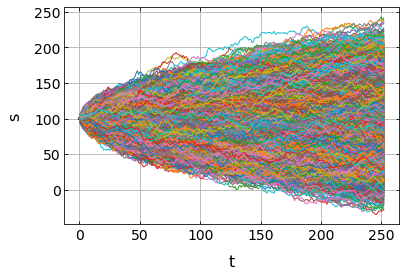

In [ ]:
import numpy
from pylab import plot, show, grid, xlabel, ylabel

# Number of realizations to generate.
m = 100000

# The Wiener process parameter.
delta = 2
# Total time.
T = 252
# Number of steps.
N = 252
# Time step size
dt = T/N

# Create an empty array to store the realizations.
s = numpy.empty((m,N+1))
# Initial values of s.
s[:, 0] = 100

#Let's see how long the simulation takes.
%time

brownian(s[:,0], N, dt, delta, out=s[:,1:])

t = numpy.linspace(0.0, N*dt, N+1)
for k in range(m):
    plot(t, s[k])
xlabel('t', fontsize=16)
ylabel('s', fontsize=16)
grid(True)
show()

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 9.78 µs


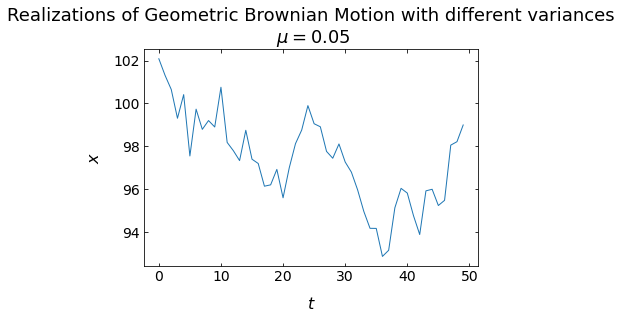

In [ ]:
%time
# Python code for the plot

import numpy as np
import matplotlib.pyplot as plt

mu = 0.05
n = 50
dt = 0.004
x0 = 100
np.random.seed(1)

# sigma = np.arange(0.8, 2, 0.2)
sigma = 0.2

x = np.exp((mu - sigma ** 2 / 2) * dt + sigma * np.random.normal(0, np.sqrt(dt), size=(1, n)).T )
x = x0 * x.cumprod(axis=0)

plt.plot(x)
plt.xlabel("$t$")
plt.ylabel("$x$")
plt.title("Realizations of Geometric Brownian Motion with different variances\n $\mu=0.05$")
plt.show()